<center>بسم الله الرحمن الرحیم</center>

Name: **Mohammad Hosein Movasaghinia**
<br>
Stu-code: **400200919**

A lot of efforts have been made in all parts of the training and various runs have been done for a long time and many results that were not suitable have been deleted.

In the following, I have tried to provide you with the best results.

To access result model, you can see them <a href="https://drive.google.com/drive/folders/1DXDsOfYWzLyNGGIMpXC_loSpn0uvNKps?usp=sharing">here</a> [My google drive] :)

# A) Preprocess (5 points):

### Download Dataset

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets list

In [ ]:
! kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

In [ ]:
! cp '/content/chest-xray-pneumonia.zip' '/content/drive/MyDrive/image-processing/dataset/'

### Prepare notebook

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!cp -r '/content/drive/MyDrive/image-processing/dataset/chest-xray-pneumonia.zip' '/content/'
!rm -r 'chest_xray'
!unzip '/content/chest-xray-pneumonia.zip' >> output_log.txt
!mkdir '/content/chest_xray/train/preview'

rm: cannot remove 'chest_xray': No such file or directory


In [1]:
import sys
import cv2
import glob
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
import os
import tensorflow as tf
from tensorflow import keras
from sklearn import metrics

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

## Data preprocessing

In [2]:
path = 'chest_xray/'
train_dir = path + 'train/'
val_dir = path + 'val/'
train_normal_dir = path + 'train/NORMAL/'
train_pneu_dir = path + 'train/PNEUMONIA/'
test_normal_dir = path + 'test/NORMAL/'
test_pneu_dir = path + 'test/PNEUMONIA/'
val_normal_dir = path + 'val/NORMAL/'
val_pneu_dir = path + 'val/PNEUMONIA/'

train_normal_cases = glob.glob(train_normal_dir + '*jpeg')
train_pneu_cases = glob.glob(train_pneu_dir + '*jpeg')
test_normal_cases = glob.glob(test_normal_dir + '*jpeg')
test_pneu_cases = glob.glob(test_pneu_dir + '*jpeg')
val_normal_cases = glob.glob(val_normal_dir + '*jpeg')
val_pneu_cases = glob.glob(val_pneu_dir + '*jpeg')

train_normal_cases = [x.replace('\\', '/') for x in train_normal_cases]
train_pneu_cases = [x.replace('\\', '/') for x in train_pneu_cases]
test_normal_cases = [x.replace('\\', '/') for x in test_normal_cases]
test_pneu_cases = [x.replace('\\', '/') for x in test_pneu_cases]
val_normal_cases = [x.replace('\\', '/') for x in val_normal_cases]
val_pneu_cases = [x.replace('\\', '/') for x in val_pneu_cases]

train_list = []
test_list = []
val_list = []

for x in train_normal_cases:
    train_list.append([x, 0])
for x in train_pneu_cases:
    train_list.append([x, 1])
for x in test_normal_cases:
    test_list.append([x, 0])
for x in test_pneu_cases:
    test_list.append([x, 1])
for x in val_normal_cases:
    val_list.append([x, 0])
for x in val_pneu_cases:
    val_list.append([x, 1])

random.shuffle(train_list)
random.shuffle(test_list)
random.shuffle(val_list)

train_df = pd.DataFrame(train_list, columns=['image', 'label'])
test_df = pd.DataFrame(test_list, columns=['image', 'label'])
val_df = pd.DataFrame(val_list, columns=['image', 'label'])

del train_list, test_list, val_list
del train_normal_cases, train_pneu_cases, test_normal_cases, test_pneu_cases, val_normal_cases, val_pneu_cases

### Visualizing data

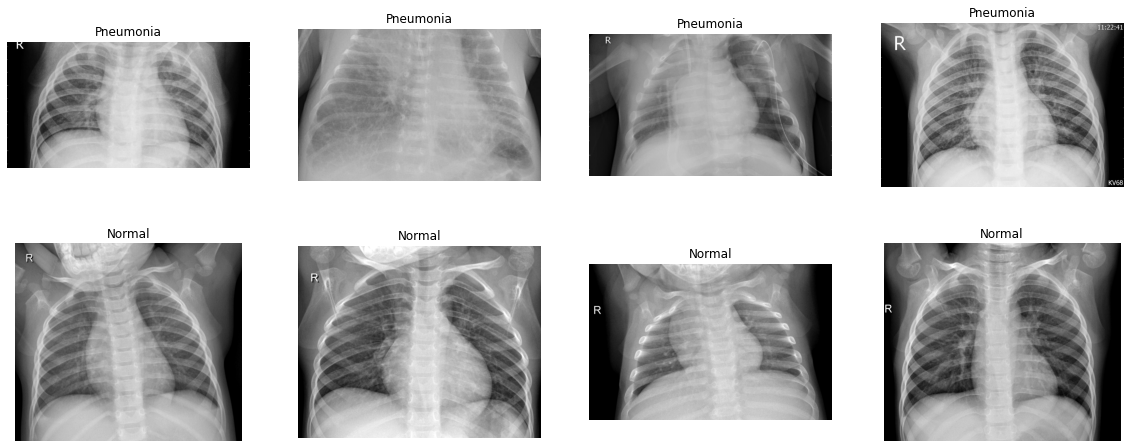

In [ ]:
plt.figure(figsize=(20,8))
for i,img_path in enumerate(train_df[train_df['label'] == 1][0:4]['image']):
    plt.subplot(2,4,i+1)
    plt.axis('off')
    img = plt.imread(img_path)
    plt.imshow(img, cmap='gray')
    plt.title('Pneumonia')
    
for i,img_path in enumerate(train_df[train_df['label'] == 0][0:4]['image']):
    plt.subplot(2,4,4+i+1)
    plt.axis('off')
    img = plt.imread(img_path)
    plt.imshow(img, cmap='gray')
    plt.title('Normal')

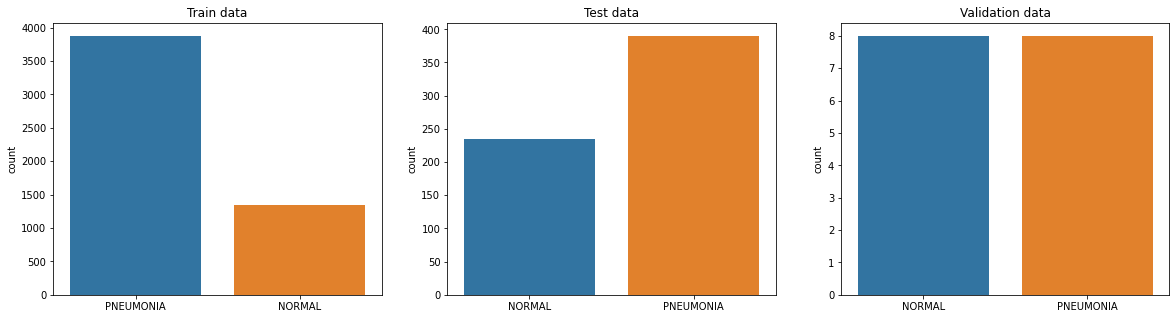

In [ ]:
plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
d1 = []
for x in train_df['label']:
    if x == 0:
        d1.append('NORMAL')
    else:
        d1.append('PNEUMONIA')
sns.countplot(d1)
plt.title('Train data')

plt.subplot(1,3,2)
d2 = []
for x in test_df['label']:
    if x == 0:
        d2.append('NORMAL')
    else:
        d2.append('PNEUMONIA')
sns.countplot(d2)
plt.title('Test data')

plt.subplot(1,3,3)
d3 = []
for x in val_df['label']:
    if x == 0:
        d3.append('NORMAL')
    else:
        d3.append('PNEUMONIA')
sns.countplot(d3)
plt.title('Validation data')

plt.show()
del d1, d2, d3

### Prepare data and augmentation

In [3]:
img_width = 160
img_height = 160

def process_data(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (img_width, img_height))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img/255.0
    temp_img = np.empty((img_width, img_height, 3))
    temp_img[:, :, 0] = img
    temp_img[:, :, 1] = img
    temp_img[:, :, 2] = img
    return temp_img

def compose_dataset(df):
    data = []
    labels = []
    for img_path, label in tqdm.tqdm(df.values):
        data.append(process_data(img_path))
        labels.append(label)
    data = np.array(data)
    labels = np.array(labels)
    return data, labels

In [4]:
X_train, y_train = compose_dataset(train_df)
X_test, y_test = compose_dataset(test_df)
X_val, y_val = compose_dataset(val_df)

print('\n\n======================\n')

print('Train data shape: {}, Labels shape: {}'.format(X_train.shape, y_train.shape))
print('Test data shape: {}, Labels shape: {}'.format(X_test.shape, y_test.shape))
print('Validation data shape: {}, Labels shape: {}'.format(X_val.shape, y_val.shape))

100%|██████████| 16/16 [00:00<00:00, 60.76it/s]




Train data shape: (5216, 160, 160, 3), Labels shape: (5216,)
Test data shape: (624, 160, 160, 3), Labels shape: (624,)
Validation data shape: (16, 160, 160, 3), Labels shape: (16,)


In [ ]:
train_datagen = keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range = 10,
    zoom_range = 0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip = True,
    vertical_flip=False,
    fill_mode='constant')

train_datagen.fit(X_train)

# B) Model and fine-tune (25 + 5 points):

## Hyper-parameter selection

In [ ]:
batch_size = 64
model_path = '/content/drive/MyDrive/image-processing/result/'
nb_epoch = 100
tr_top_weights_path = '/content/drive/MyDrive/image-processing/result/tr_top_model_weights.h5'
my_top_weights_path = '/content/drive/MyDrive/image-processing/result/my_top_model_weights.h5'
my_base_model_path = '/content/drive/MyDrive/image-processing/result/my_base_model.h5'
my_tr_model_path = '/content/drive/MyDrive/image-processing/result/my_tr_model.h5'

## My Model from scratch

### Define My-Model

In [ ]:
def build_model():
    input = keras.Input(shape=(img_width, img_height, 3), name='input')

    # ==================== block_1 ====================
    b1_conv1 = keras.layers.Conv2D(64, (3,3), activation='relu', padding='same', name='b1_conv1')(input)
    b1_conv2 = keras.layers.Conv2D(64, (3,3), activation='relu', padding='same', name='b1_conv2')(b1_conv1)
    b1_out = keras.layers.MaxPooling2D((2,2), name='b1_pool')(b1_conv2)

    # ==================== block_2 ====================
    b2_conv1 = keras.layers.SeparableConv2D(128, (3,3), activation='relu', padding='same', name='b2_conv1')(b1_out)
    b2_conv2 = keras.layers.SeparableConv2D(128, (3,3), activation='relu', padding='same', name='b2_conv2')(b2_conv1)
    b2_out = keras.layers.MaxPooling2D((2,2), name='b2_pool')(b2_conv2)

    # ==================== block_3 ====================
    b3_conv1 = keras.layers.SeparableConv2D(128, (3,3), activation='relu', padding='same', name='b3_conv1')(b2_out)
    b3_bn1 = keras.layers.BatchNormalization(name='b3_bn1')(b3_conv1)
    b3_add = keras.layers.add([b2_out, b3_bn1])
    b3_conv2 = keras.layers.SeparableConv2D(256, (3,3), activation='relu', padding='same', name='b3_conv2')(b3_add)
    b3_bn2 = keras.layers.BatchNormalization(name='b3_bn2')(b3_conv2)
    b3_conv3 = keras.layers.SeparableConv2D(256, (3,3), activation='relu', padding='same', name='b3_conv3')(b3_bn2)
    b3_out = keras.layers.MaxPooling2D((2,2), name='b3_pool')(b3_conv3)

    # ==================== block_4 ====================
    b4_conv1 = keras.layers.SeparableConv2D(256, (3,3), activation='relu', padding='same', name='b4_conv1')(b3_out)
    b4_bn1 = keras.layers.BatchNormalization(name='b4_bn1')(b4_conv1)
    b4_add = keras.layers.add([b3_out, b4_bn1])
    b4_conv2 = keras.layers.SeparableConv2D(512, (3,3), activation='relu', padding='same', name='b4_conv2')(b4_add)
    b4_bn2 = keras.layers.BatchNormalization(name='b4_bn2')(b4_conv2)
    b4_conv3 = keras.layers.SeparableConv2D(512, (3,3), activation='relu', padding='same', name='b4_conv3')(b4_bn2)
    b4_out = keras.layers.MaxPooling2D((2,2), name='b4_pool')(b4_conv3)

    # ==================== block_5 ====================
    b5_avp = keras.layers.GlobalAveragePooling2D(name='b5_avp1')(b4_out)
    output = keras.layers.Dense(1, name='output', activation='sigmoid')(b5_avp)
    
    model = keras.Model(inputs=input, outputs=output)
    return model

In order to optimize the model I use `Adam optimizer`, and for loss, I used `Binary cross entropy` based on the sigmoid output last fully-connected layer of my model.

In [ ]:
my_model = build_model()
my_model.compile(optimizer='adam', 
              loss=keras.losses.BinaryCrossentropy(from_logits=False), 
              metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()])

### Training my model from scratch

Let's train the model and save each epoch's accuracy, precision, and recall in the `my_history` variable.

In [ ]:
callbacks_list = [
    keras.callbacks.ModelCheckpoint(my_top_weights_path, 
                                    monitor='val_accuracy', 
                                    verbose=1, 
                                    save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                  patience=20, 
                                  verbose=0)
]

my_history = my_model.fit(train_datagen.flow(X_train, y_train, batch_size=batch_size), 
          validation_data=(X_val, y_val), 
          epochs=nb_epoch,
          callbacks=callbacks_list)

my_model.save(my_base_model_path)

Epoch 1/100
82/82 [==============================] - ETA: 0s - loss: 0.3919 - accuracy: 0.8299 - precision_1: 0.8425 - recall_1: 0.9484
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to /content/drive/MyDrive/image-processing/result/my_top_model_weights.h5
82/82 [==============================] - 43s 500ms/step - loss: 0.3919 - accuracy: 0.8299 - precision_1: 0.8425 - recall_1: 0.9484 - val_loss: 0.7469 - val_accuracy: 0.5000 - val_precision_1: 0.5000 - val_recall_1: 1.0000
Epoch 2/100
82/82 [==============================] - ETA: 0s - loss: 0.2066 - accuracy: 0.9214 - precision_1: 0.9416 - recall_1: 0.9533
Epoch 2: val_accuracy did not improve from 0.50000
82/82 [==============================] - 37s 448ms/step - loss: 0.2066 - accuracy: 0.9214 - precision_1: 0.9416 - recall_1: 0.9533 - val_loss: 0.7116 - val_accuracy: 0.5000 - val_precision_1: 0.5000 - val_recall_1: 1.0000
Epoch 3/100
82/82 [==============================] - ETA: 0s - loss: 0.1720 - accuracy: 0.934

### load model

In [ ]:
my_base_model = keras.models.load_model(my_top_weights_path)

### Evaluation

In [ ]:
score = my_base_model.evaluate(X_test, y_test)

20/20 [==============================] - 13s 84ms/step - loss: 0.2152 - accuracy: 0.9295 - precision_1: 0.9391 - recall_1: 0.9487


In [ ]:
print('Test evaluation:')
print(f'> loss:\t\t{score[0]:.4f}\n> accuracy:\t{score[1]:.4f}\
\n> precision:\t{score[2]:.4f}\n> recall:\t{score[3]:.4f}')

Test evaluation:
> loss:		0.2152
> accuracy:	0.9295
> precision:	0.9391
> recall:	0.9487


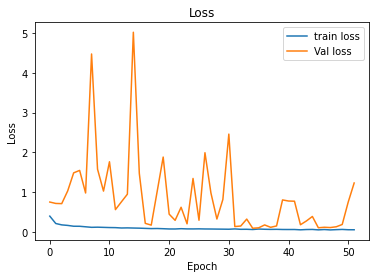

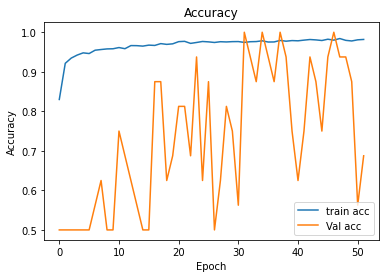

In [ ]:
import matplotlib.pyplot as plt

plt.plot(my_history.history['loss'], label='train loss')
plt.plot(my_history.history['val_loss'], label='Val loss')
plt.legend()
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

plt.plot(my_history.history['accuracy'], label='train acc')
plt.plot(my_history.history['val_accuracy'], label='Val acc')
plt.legend()
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

In [ ]:
y_test_pred = my_base_model.predict(X_test)
y_train_pred = my_base_model.predict(X_train)
y_val_pred = my_base_model.predict(X_val)

1/1 [==============================] - 0s 21ms/step


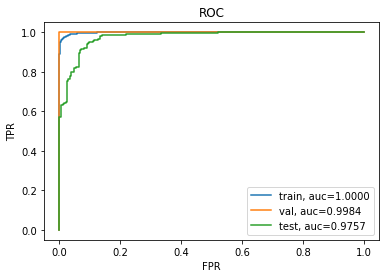

In [ ]:
fpr_train, tpr_train, _ = metrics.roc_curve(y_train,  y_train_pred)
fpr_val, tpr_val, _ = metrics.roc_curve(y_val,  y_val_pred)
fpr_test, tpr_test, _ = metrics.roc_curve(y_test,  y_test_pred)

auc_val = metrics.roc_auc_score(y_train, y_train_pred)
auc_train = metrics.roc_auc_score(y_val, y_val_pred)
auc_test = metrics.roc_auc_score(y_test, y_test_pred)

plt.plot(fpr_train, tpr_train, label=f"train, auc={auc_train:.4f}")
plt.plot(fpr_val, tpr_val, label=f"val, auc={auc_val:.4f}")
plt.plot(fpr_test, tpr_test, label=f"test, auc={auc_test:.4f}")
plt.legend(loc=4)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC')
plt.show()

As you see in previous results the model did not overfit to training data. My model achieves good accuracy, AUC, precision, and recall. But I used transfer learning in the next parts and achieve better accuracy, AUC, precision, and recall.

## Transfer Learning

I get better accuracy, precision, recall and AUC with transfer learning.

### Declearing transfer model

I loaded the `Xception` model without the last dense layers, which were pre-trained on `imagenet` dataset. Then I fine-tuned it based on our dataset. I freeze the 116 first layers of the model and fine-tuned the other layers.

> Why I use this model?<br>
According to the table <a href="https://keras.io/api/applications/" rel="noopener noreferrer" target="_blank">here</a>, this model has a relatively average size and parameter number, while, it has a very **high accuracy** and can be trained on the GPU in a short time.

In [ ]:
def xception_transfer_model_build():
    base_model = keras.applications.Xception(weights='imagenet', 
                                             input_shape=(img_width, img_height, 3), 
                                             include_top=False)

    train_from = 110
    for layer in base_model.layers[:train_from]:
        layer.trainable = False
    for layer in base_model.layers[train_from:]:
        layer.trainable = True

    x = keras.layers.GlobalAveragePooling2D()(base_model.layers[-1].output)
    outputs = keras.layers.Dense(1, activation='sigmoid')(x)
    model = keras.Model(inputs=base_model.inputs, outputs=outputs)

    model.compile(optimizer='adam', 
              loss=keras.losses.BinaryCrossentropy(from_logits=False), 
              metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()])
    return model

tr_model = xception_transfer_model_build()
tr_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 79, 79, 32)   864         ['input_3[0][0]']                
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 79, 79, 32)  128         ['block1_conv1[0][0]']           
 ation)                                                                                           
                                                                                            

### fine-tuning

In [ ]:
callbacks_list = [
    keras.callbacks.ModelCheckpoint(tr_top_weights_path, 
                                    monitor='val_accuracy', 
                                    verbose=1, 
                                    save_best_only=True),
    keras.callbacks.ModelCheckpoint(filepath=model_path+'tr_model.{epoch:03d}.h5'),
    keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=25, verbose=1)
]

tr_history = tr_model.fit(train_datagen.flow(X_train, y_train, batch_size=batch_size), 
                          validation_data=(X_val, y_val), 
                          epochs=nb_epoch, 
                          callbacks=callbacks_list)

tr_model.save(my_tr_model_path)

Epoch 1/100
82/82 [==============================] - ETA: 0s - loss: 0.1823 - accuracy: 0.9312 - precision_2: 0.9571 - recall_2: 0.9499
Epoch 1: val_accuracy improved from -inf to 0.62500, saving model to /content/drive/MyDrive/image-processing/result/tr_top_model_weights.h5
82/82 [==============================] - 37s 406ms/step - loss: 0.1823 - accuracy: 0.9312 - precision_2: 0.9571 - recall_2: 0.9499 - val_loss: 3.8899 - val_accuracy: 0.6250 - val_precision_2: 1.0000 - val_recall_2: 0.2500
Epoch 2/100
82/82 [==============================] - ETA: 0s - loss: 0.1067 - accuracy: 0.9638 - precision_2: 0.9772 - recall_2: 0.9739
Epoch 2: val_accuracy improved from 0.62500 to 0.87500, saving model to /content/drive/MyDrive/image-processing/result/tr_top_model_weights.h5
82/82 [==============================] - 36s 440ms/step - loss: 0.1067 - accuracy: 0.9638 - precision_2: 0.9772 - recall_2: 0.9739 - val_loss: 0.6385 - val_accuracy: 0.8750 - val_precision_2: 1.0000 - val_recall_2: 0.7500
E

In [ ]:
f = open(model_path+'tr_history.txt', 'w')
for k in tr_history.history:
    f.write(f'{k}\t')
    for x in tr_history.history[k]:
        f.write(f'{x}\t')
    f.write('\n')
f.close()

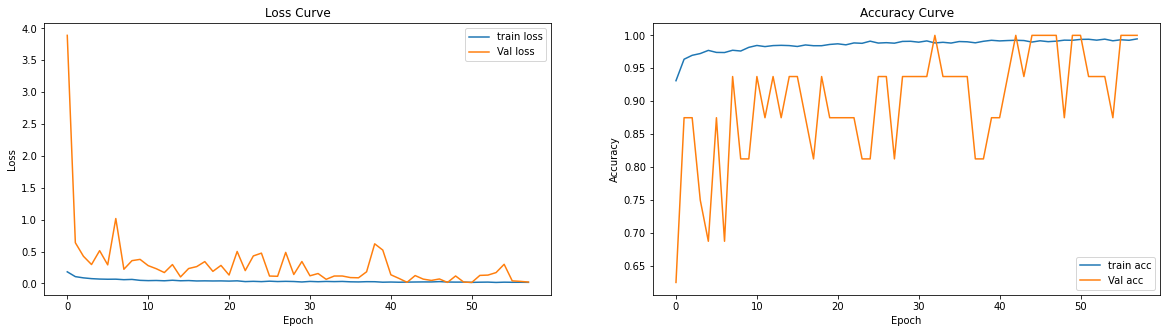

In [ ]:
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.plot(tr_history.history['loss'], label='train loss')
plt.plot(tr_history.history['val_loss'], label='Val loss')
plt.legend()
plt.title('Loss Curve')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.subplot(1,2,2)
plt.plot(tr_history.history['accuracy'], label='train acc')
plt.plot(tr_history.history['val_accuracy'], label='Val acc')
plt.legend()
plt.title('Accuracy Curve')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

### Evaluation

In [ ]:
tr_model = keras.models.load_model(tr_top_weights_path)

In [ ]:
score = tr_model.evaluate(X_test, y_test)

20/20 [==============================] - 13s 94ms/step - loss: 0.2269 - accuracy: 0.9423 - precision_2: 0.9470 - recall_2: 0.9615


I get improved the **accuracy** to **94.2%**. (It is more than all accuracy achieved in top notebooks in kaggle of this dataset)

In [ ]:
print('Test evaluation:')
print(f'> loss:\t\t{score[0]:.4f}\n> accuracy:\t{score[1]:.4f}\
\n> precision:\t{score[2]:.4f}\n> recall:\t{score[3]:.4f}')

Test evaluation:
> loss:		0.2269
> accuracy:	0.9423
> precision:	0.9470
> recall:	0.9615


In [ ]:
y_test_pred = tr_model.predict(X_test)
y_train_pred = tr_model.predict(X_train)
y_val_pred = tr_model.predict(X_val)

1/1 [==============================] - 0s 29ms/step


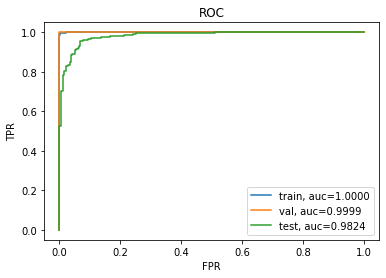

In [ ]:
fpr_train, tpr_train, _ = metrics.roc_curve(y_train,  y_train_pred)
fpr_val, tpr_val, _ = metrics.roc_curve(y_val,  y_val_pred)
fpr_test, tpr_test, _ = metrics.roc_curve(y_test,  y_test_pred)

auc_val = metrics.roc_auc_score(y_train, y_train_pred)
auc_train = metrics.roc_auc_score(y_val, y_val_pred)
auc_test = metrics.roc_auc_score(y_test, y_test_pred)

plt.plot(fpr_train, tpr_train, label=f"train, auc={auc_train:.4f}")
plt.plot(fpr_val, tpr_val, label=f"val, auc={auc_val:.4f}")
plt.plot(fpr_test, tpr_test, label=f"test, auc={auc_test:.4f}")
plt.legend(loc=4)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC')
plt.show()

In the above results, I got better accuracy, AUC, precision, and recall, than my simple residual model that was created from scratch.

# C) Data balancing (5 points)

Normally, the threshold of data `imbalance` is considered to be `0.5`. Therefore, the training data is not balanced, but the rest of the data is balanced. In the next cells, we use `different weight` to each class to balance the training process.

In [ ]:
print('Check balancing of data:[normal/pneumonia]')
print('> Train:\t', f"{(len(train_df['label'])-sum(train_df['label']))/sum(train_df['label']):.2f}")
print('> Validation:\t', f"{(len(val_df['label'])-sum(val_df['label']))/sum(val_df['label']):.2f}")
print('> Test:\t\t', f"{(len(test_df['label'])-sum(test_df['label']))/sum(test_df['label']):.2f}")

Check balancing of data:[normal/pneumonia]
> Train:	 0.35
> Validation:	 1.00
> Test:		 0.60


## Training my created model

In [6]:
my_aug_top_weights_path = '/content/drive/MyDrive/image-processing/result/my_aug_top_model_weights.h5'
my_aug_model_path = '/content/drive/MyDrive/image-processing/result/my_aug_model.h5'
batch_size = 64
nb_epoch = 100

We give a weighting according to the number of each class so that the loss is calculated based on this weighting. Therefore, the problem of not balancing the number of classes' data is almost solved.

In [ ]:
counts = np.bincount(y_train)
weight_for_0 = 1+(1.0 / counts[0])
weight_for_1 = 1+(1.0 / counts[1])
class_weight = {0: weight_for_0, 1: weight_for_1}

In [ ]:
my_model_aug = build_model()
my_model_aug.compile(optimizer='nadam', 
                     loss=keras.losses.BinaryCrossentropy(from_logits=False), 
                     metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()])

callbacks_list = [
    keras.callbacks.ModelCheckpoint(my_aug_top_weights_path, 
                                    monitor='val_accuracy', 
                                    verbose=1, 
                                    save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                  patience=20, 
                                  verbose=0)
]

my_aug_history = my_model_aug.fit(train_datagen.flow(X_train, y_train, batch_size=batch_size), 
                                  validation_data=(X_val, y_val), 
                                  epochs=nb_epoch,
                                  class_weight=class_weight,
                                  callbacks=callbacks_list)

my_model_aug.save(my_aug_model_path)

Epoch 1/100
82/82 [==============================] - ETA: 0s - loss: 0.3729 - accuracy: 0.8393 - precision_2: 0.8513 - recall_2: 0.9497
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to /content/drive/MyDrive/image-processing/result/my_aug_top_model_weights.h5
82/82 [==============================] - 43s 474ms/step - loss: 0.3729 - accuracy: 0.8393 - precision_2: 0.8513 - recall_2: 0.9497 - val_loss: 0.7125 - val_accuracy: 0.5000 - val_precision_2: 0.5000 - val_recall_2: 1.0000
Epoch 2/100
82/82 [==============================] - ETA: 0s - loss: 0.1893 - accuracy: 0.9229 - precision_2: 0.9449 - recall_2: 0.9517
Epoch 2: val_accuracy improved from 0.50000 to 0.56250, saving model to /content/drive/MyDrive/image-processing/result/my_aug_top_model_weights.h5
82/82 [==============================] - 39s 469ms/step - loss: 0.1893 - accuracy: 0.9229 - precision_2: 0.9449 - recall_2: 0.9517 - val_loss: 0.6905 - val_accuracy: 0.5625 - val_precision_2: 0.6667 - val_recall_2: 

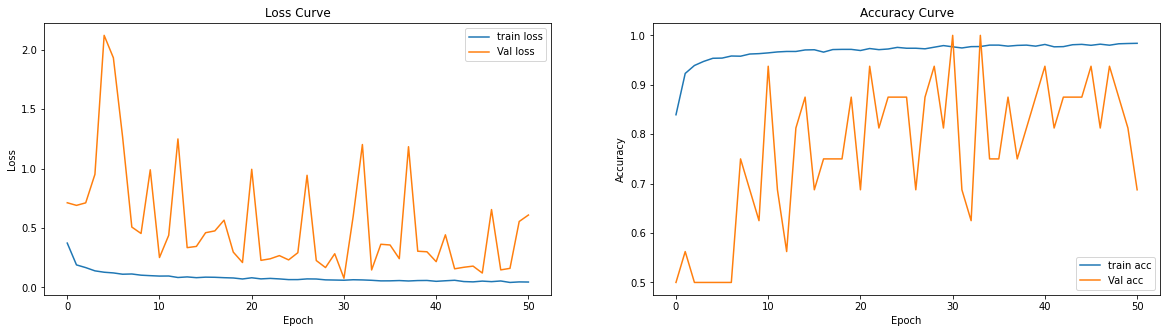

In [10]:
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.plot(my_aug_history.history['loss'], label='train loss')
plt.plot(my_aug_history.history['val_loss'], label='Val loss')
plt.legend()
plt.title('Loss Curve')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.subplot(1,2,2)
plt.plot(my_aug_history.history['accuracy'], label='train acc')
plt.plot(my_aug_history.history['val_accuracy'], label='Val acc')
plt.legend()
plt.title('Accuracy Curve')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

## Evaluation

In [7]:
my_model_aug = keras.models.load_model(my_aug_top_weights_path)

As it is clear in the following results, the accuracy has increased compared to the case where the data were imbalanced and no method appropriate to the state of the data was considered in the model. (compare to model that was created from scratch)

In [7]:
score = my_model_aug.evaluate(X_test, y_test)
print('Test evaluation:')
print(f'> loss:\t\t{score[0]:.4f}\n> accuracy:\t{score[1]:.4f}\
\n> precision:\t{score[2]:.4f}\n> recall:\t{score[3]:.4f}')

20/20 [==============================] - 11s 81ms/step - loss: 0.2418 - accuracy: 0.9359 - precision_2: 0.9310 - recall_2: 0.9692
Test evaluation:
> loss:		0.2418
> accuracy:	0.9359
> precision:	0.9310
> recall:	0.9692


In [8]:
y_test_pred = my_model_aug.predict(X_test)
y_train_pred = my_model_aug.predict(X_train)
y_val_pred = my_model_aug.predict(X_val)

1/1 [==============================] - 0s 21ms/step


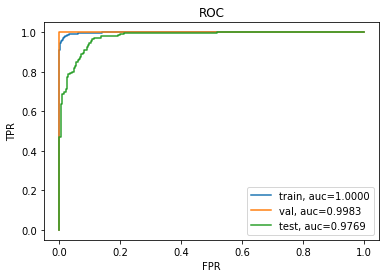

In [9]:
fpr_train, tpr_train, _ = metrics.roc_curve(y_train,  y_train_pred)
fpr_val, tpr_val, _ = metrics.roc_curve(y_val,  y_val_pred)
fpr_test, tpr_test, _ = metrics.roc_curve(y_test,  y_test_pred)

auc_val = metrics.roc_auc_score(y_train, y_train_pred)
auc_train = metrics.roc_auc_score(y_val, y_val_pred)
auc_test = metrics.roc_auc_score(y_test, y_test_pred)

plt.plot(fpr_train, tpr_train, label=f"train, auc={auc_train:.4f}")
plt.plot(fpr_val, tpr_val, label=f"val, auc={auc_val:.4f}")
plt.plot(fpr_test, tpr_test, label=f"test, auc={auc_test:.4f}")
plt.legend(loc=4)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC')
plt.show()

# D) Interpretation (15 points)

In order to interpret how the model makes decisions on the data, it is possible to obtain the effect of each image pixel by calculating the derivative of the output relative to the input layer. One of the packages that performs this operation for us is `tf-explain`, which uses the `GradCam` function on the model to output an image in accordance with the input data, in which it has determined with `heatmap` which points have the most impact on the decision.

In [ ]:
!pip install tf_explain
from tf_explain.callbacks.grad_cam import GradCAM
import tqdm
!rm -r 'explain'
!mkdir 'explain'
tf_explain_dir = 'explain/'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 1.5 MB/s 
rm: cannot remove 'explain': No such file or directory


As you can see in the cell below, the model for the test data calculates the gradient with respect to the inputs and provides the same input image as the output along with a heatmap on it that determines the importance of each pixel input image.

In [ ]:
explainer = GradCAM()

for i, x in tqdm.tqdm(enumerate(X_test)):
    grid = explainer.explain(
        ([keras.preprocessing.image.img_to_array(x)], None), 
        tr_model, 
        class_index=0)
    explainer.save(grid, tf_explain_dir, f"grad_cam_testset_{i}.png")

624it [02:03,  5.06it/s]


In [ ]:
!cp -r 'explain/' '/content/drive/MyDrive/image-processing/result/'

In [ ]:
tr_pred = tr_model.predict(X_test)
y_pred = []
for x in tr_pred:
    if x > 0.5:
        y_pred.append(1)
    else:
        y_pred.append(0)
del tr_pred

test_grad_cam_df = {}
test_grad_cam_df['path'] = [f'/content/drive/MyDrive/image-processing/result/explain/grad_cam_testset_{i}.png' for i in range(len(X_test))]
test_grad_cam_df['label'] = y_test
test_grad_cam_df['pred'] = y_pred

test_grad_cam_df = pd.DataFrame(test_grad_cam_df)

20/20 [==============================] - 70s 4s/step


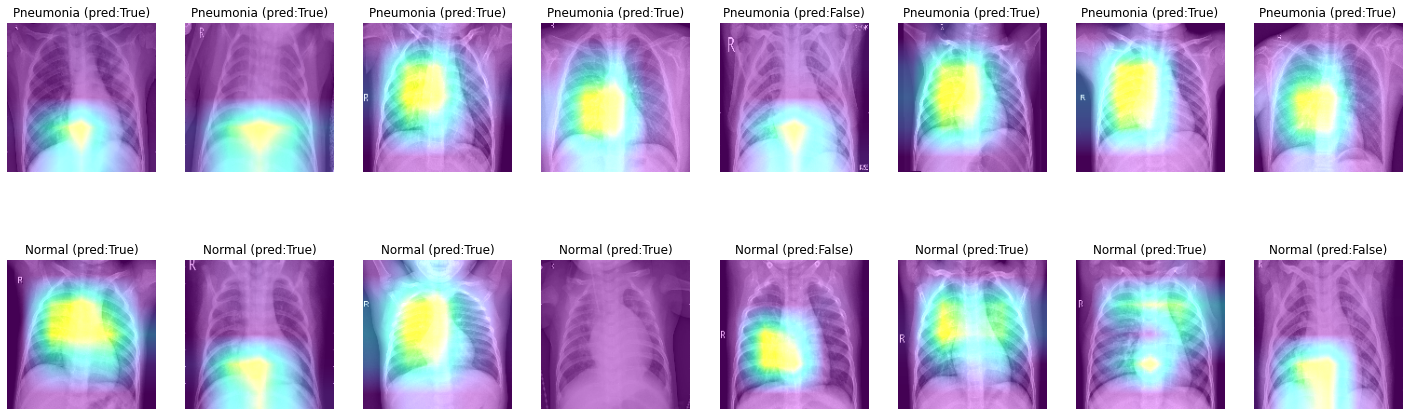

In [ ]:
n = 8
pneumonia = test_grad_cam_df[test_grad_cam_df['label'] == 1][2*n:3*n]
normal = test_grad_cam_df[test_grad_cam_df['label'] == 0][2*n:3*n]

plt.figure(figsize=(25,8))

for i, img_path, label, pred in zip(range(n), pneumonia['path'], pneumonia['label'], pneumonia['pred']):
    plt.subplot(2,n,i+1)
    plt.axis('off')
    img = plt.imread(img_path)
    plt.imshow(img)
    plt.title(f'Pneumonia (pred:{str(bool(pred))})')
    
for i, img_path, label, pred in zip(range(n), normal['path'], normal['label'], normal['pred']):
    plt.subplot(2,n,n+i+1)
    plt.axis('off')
    img = plt.imread(img_path)
    plt.imshow(img)
    plt.title(f'Normal (pred:{str(not bool(pred))})')

As seen in the images above, the model has been able to recognize the importance of lungs in the classification and make decisions according to the area related to the lungs in the images. (Of course, it has mistakes in some cases. But in general, according to the good evaluation criteria obtained in the previous parts for the transferred model, it can be concluded that the model works relatively well.)